In [1]:
import erddapy
from erddapy import ERDDAP
import numpy as np
import pandas as pd
import xarray as xr
import cf_xarray as cfxr
import datetime
import netCDF4
from netCDF4 import Dataset

import matplotlib
from matplotlib import pyplot as plt

In [2]:
import pathlib

import holoviews as hv
import hvplot.pandas # noqa
import hvplot.xarray
import numpy as np
import pandas as pd
import panel as pn


pn.extension(template='fast')

In [3]:
def get_erddap_data(erddap_url, dataset, data_protocol="griddap", variables=None, constraints=None):
    """
    Function: get_erddap_data
    This function uses the erddapy python library to access data from ERDDAP servers,
    and to return it to users in convenient formats for python users.
    Data can be pulled from "tabledap" or "griddap" formats, with different
    output types, depending on the dap type.
    
    Inputs:
    erddap_url    - The url address of the erddap server to pull data from
    variables     - The selected variables within the dataset.
    data_protocol - The erddap data protocol for the chosen dataset.
                    Options include "tabledap" or "griddap"
                    The default option is given as "griddap"
    dataset       - The ID for the relevant dataset on the erddap server
                    If no variables are given, it is assumed that all variables
                    will be pulled.
    constraints   - These are set by the user to help restrict the data pull
                    to only the area and timeframe of interest.
                    If no constraints are given, all data in a dataset is pulled.
                    Constraints should be given as a dictionary, where
                    each entry is a bound and/or selection of a specific axis variable
                    Exs. {"longitude<=": "min(longitude)+10", "longitude>=": "0"}
                         {"longitude=": "140", "time>=": "max(time)-30"}
    
    Outputs:
    erddap_data   - This variable contains the pulled data from the erddap server.
                    If the data_protocol is "griddap",  then erddap_data is an xarray dataset
                    If the data_protocol is "tabledap", then erddap_data is a pandas dataframe
    """
    
    import erddapy
    from erddapy import ERDDAP
    import pandas as pd
    import xarray
    
    
    ############################################
    # Set-up the connection to the ERDDAP server
    ############################################
    
    # Connect to the erddap server
    e = ERDDAP(server=erddap_url, protocol=data_protocol, response='csv')
    
    # Identify the dataset of interest
    e.dataset_id = dataset
    
    
    #########################################
    # Pull the data, based upon protocol type
    #########################################
    
    # GRIDDAP Protocol
    if data_protocol == "griddap":
        
        # Initialize the connection
        e.griddap_initialize()

        # Update the constraints
        if constraints is not None:
            e.constraints.update(constraints)
            e.griddap_initialize()
            
        # Update the selection of the variables
        if variables is not None:
            e.variables = variables

        erddap_data = e.to_xarray()
    
    # TABLEDAP Protocol
    elif data_protocol == "tabledap":

        # Update the constraints
        if constraints is not None:
            e.constraints = constraints
            
        # Update the selection of the variables
        if variables is not None:
            e.variables = variables
            
        erddap_data = e.to_pandas()
    
    # Invalid protocol given
    else:
        print('Invalid ERDDAP protocol. Given protocol is: ' + data_protocol)
        print('Valid protocols include "griddap" or "tabledap". Please restart and try again with a valid protocol')
        erddap_data = None
    
    
    #############################
    return erddap_data

In [4]:
def datetime_to_ordinal_withseconds(x):
    """
    Converts a datetime object to an ordinal number, 
    taking into account both the date and time parts of the input.
    The resulting ordinal number represents the number of days 
    since January 1, 1 AD, at 12:00 AM, 
    plus a fractional portion representing the time part of the input.
    """
    # Import libraries
    import numpy as np
    import pandas as pd
    import datetime

    # Extract year, month, day, hour, minute, 
    # and second components from input datetime object
    year = x.year
    month = x.month
    day = x.day
    hour = x.hour
    minute = x.minute
    second = x.second

    # Create a new datetime object using the 
    # extracted year, month, and day components
    date_obj = datetime.datetime(year, month, day)

    # Get the ordinal number of the date
    date_ordinal = datetime.datetime.toordinal(date_obj)

    # Calculate the partial ordinal number for the time part of the input
    date_partial = (hour + (minute + (second / 60)) / 60) / 24

    # Combine the date and time ordinal numbers
    x_ordinal = date_ordinal + date_partial

    # Return the final ordinal number
    return x_ordinal

In [35]:
nwem_url = 'http://nwem.apl.washington.edu/erddap'

nwem_dataset = 'orca3_L3_depthgridded_025'

variables = ["sea_water_temperature",
             "sea_water_practical_salinity",
             "mass_concentration_of_oxygen_in_sea_water"]

constraints = {"cast_start_time>=":datetime.datetime(2010,1,1).strftime('%Y-%m-%dT%H:%M:%SZ')}
#constraints = {"cast_start_time>=": "max(cast_start_time)-365"}

nwem_grid = get_erddap_data(nwem_url, nwem_dataset, 
                variables=variables, 
                constraints=constraints,
                data_protocol="griddap")

In [36]:
nwem_grid

<xarray.Dataset>
Dimensions:                                    (cast_start_time: 7034,
                                                depth: 401)
Coordinates:
  * cast_start_time                            (cast_start_time) datetime64[ns] ...
  * depth                                      (depth) float64 0.0 ... 100.0
Data variables:
    sea_water_temperature                      (cast_start_time, depth) float64 ...
    sea_water_practical_salinity               (cast_start_time, depth) float64 ...
    mass_concentration_of_oxygen_in_sea_water  (cast_start_time, depth) float64 ...
Attributes: (12/34)
    author:                        Seth Travis
    buoy_designation:              ORCA3
    buoy_latitude:                 47.90733333 degrees N
    buoy_longitude:                -122.627 degrees E
    buoy_name:                     Hansville
    buoy_reference_number:         3
    ...                            ...
    license:                       The data may be used and redistributed for...
    sourceUrl:                     (local files)
    standard_name_vocabulary:      CF Standard Name Table v70
    summary:                       The Northwest Environmental Moorings progr...
    title:                         ORCA3 - Northbuoy - L3 Depth Gridded Data ...
    water_depth:                   100 meters

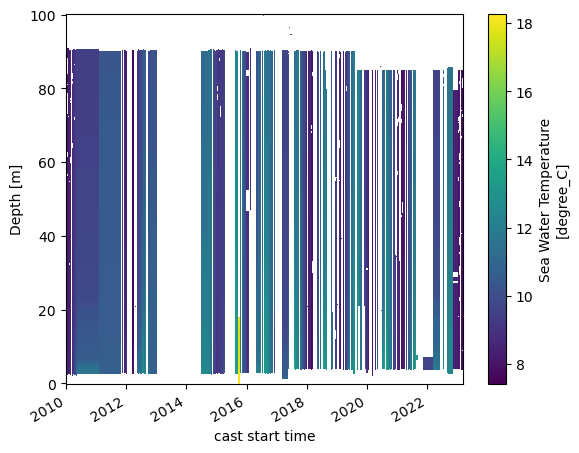

In [37]:
nwem_grid.sea_water_temperature.plot(x='cast_start_time')

In [38]:
cast_dates = [datetime_to_ordinal_withseconds(pd.Timestamp(ii.values))
              for ii in nwem_grid.cast_start_time]

In [39]:
nwem_grid['cast_dates'] = (['cast_start_time'], cast_dates)

In [49]:
nowtime = datetime.datetime.now()
nowday = datetime.datetime(nowtime.year,
                           nowtime.month,
                           nowtime.day)

startday = datetime.datetime(2010,1,1)

nowdate = datetime.datetime.toordinal(nowday)
startdate = datetime.datetime.toordinal(startday)

date_slider = pn.widgets.FloatSlider(name='Earliest Date', 
                                     start=startdate, 
                                     end=nowdate, 
                                     value=(nowdate - 365)).servable(target='sidebar')


date_slider2 = pn.widgets.FloatSlider(name='Latest Date', 
                                     start=startdate, 
                                     end=nowdate, 
                                     value=nowdate)

In [45]:
nwem_interactive = nwem_grid.interactive()

In [46]:
nwem_interactive

In [31]:
date_ref = datetime.datetime(1970,1,1)
dateord_ref = datetime.datetime.toordinal(date_ref)

In [50]:
date_slider

FloatSlider(end=738742, name='Earliest Date', start=733773, value=738377)

In [52]:
def plot_timerange(nwem_interactive, date_slider):
    
    nwem_to_plot = nwem_interactive.where(nwem_interactive.cast_dates > date_slider,
                                          drop=True)
    dates_to_plot = nwem_to_plot.cast_start_time.values
    depths_to_plot = nwem_to_plot.depth.values
    sst_to_plot = nwem_to_plot.sea_water_temperature.values
    
    fig = plt.Figure()
    ax = fig.add_subplot(111)
    cb = ax.pcolor(dates_to_plot, depths_to_plot, sst_to_plot.T)
    ax.invert_yaxis()
    fig.colorbar(cb,ax=ax)
    
    #(nwem_interactive.where(nwem_interactive.cast_dates > date_slider,drop=True).
    # sea_water_temperature.plot(x='cast_start_time'))
    
    return fig   
    

In [16]:
date_slider2

FloatSlider(end=738742, name='Latest Date', start=733773, value=738742)

Row
    [0] Markdown(str)
    [1] Matplotlib(Figure)
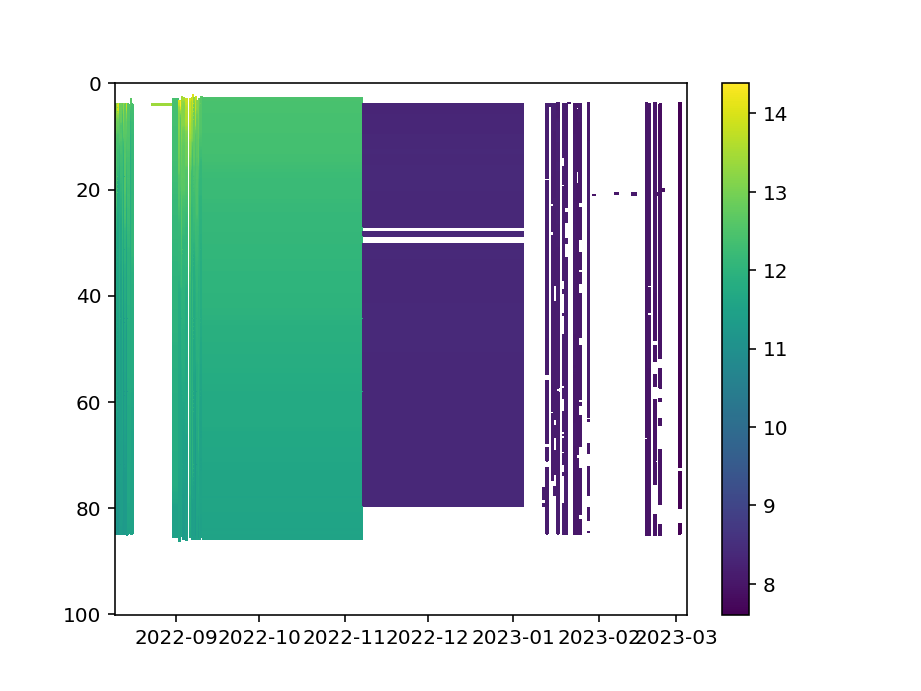

In [53]:
mpl = pn.pane.Matplotlib(
    pn.bind(plot_timerange, nwem_interactive, date_slider)
)

pn.Row(
    'Buoy data', mpl
).servable(target='main')